In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import math
import pickle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers as tfkl, models as tfk
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/filtered6_dataset.csv"
file_path_beat = "/content/drive/My Drive/dataset_beats.pkl"

# Load Data

In [ ]:
# Load the csv file
df = pd.read_csv(file_path)
df

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,total_power,dominant_frequency,fft1,fft2,fft3,fft4,fft5,power_ratio,subject_id,label
0,0.180077,0.218750,0.421875,0.640625,0.182377,-0.129712,0.035568,7.611720,0.234375,0.952541,...,0.005288,1.560976,2.916588,5.748035,1.265770,0.279039,0.107661,4.196146,S001,N
1,0.116188,0.218750,0.421875,0.640625,0.116940,-0.142917,-0.011494,6.401779,0.187500,0.632139,...,0.004130,1.560976,0.942475,4.903048,1.170524,0.241586,0.010196,3.693372,S001,N
2,0.121023,0.218750,0.421875,0.648438,0.121389,-0.140039,-0.005806,6.333089,0.195312,0.619593,...,0.004146,1.560976,0.476099,4.853160,1.269356,0.336398,0.088376,3.344450,S001,N
3,0.138627,0.171875,0.328125,0.500000,0.139091,-0.075619,0.046283,4.516074,0.218750,0.440520,...,0.001843,2.000000,2.962109,3.009263,0.748133,0.258063,0.116591,3.100019,S001,N
4,0.068806,0.171875,0.328125,0.781250,0.069293,-0.078520,-0.000457,2.713990,0.156250,0.146076,...,0.001081,2.000000,0.029221,2.115377,0.439297,0.044651,0.016416,2.799579,S001,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202383,0.499998,0.226562,0.437500,0.734375,0.499998,-0.359638,0.019270,17.218056,0.140625,5.511694,...,0.040839,1.505882,1.637929,12.890518,7.828788,2.320222,0.230425,3.690086,S118,N
202384,0.550178,0.250000,0.476562,0.726562,0.550178,-0.391033,0.022467,19.873999,0.156250,7.070209,...,0.053460,1.376344,2.089437,14.987465,9.752007,2.597727,0.096489,4.069932,S118,N
202385,0.502216,0.250000,0.476562,0.726562,0.502216,-0.390489,-0.019317,19.858934,0.140625,6.572488,...,0.049566,1.376344,1.796471,14.453389,9.242147,3.022286,0.498451,4.203525,S118,N
202386,0.353672,0.234375,0.445312,0.679688,0.353672,-0.475695,-0.049775,14.960191,0.125000,4.601866,...,0.028173,2.942529,4.330394,8.686023,10.318711,2.294286,0.902660,5.407155,S118,N


In [ ]:
# Load the DataFrame from a pickle file
df_beats = pd.read_pickle(file_path_beat)
df_beats

,beat,label,subject_id
0,"[-0.08352822059318818, -0.07741457418066558, -...",N,S001
1,"[-0.1283664400521754, -0.1254937239009242, -0....",N,S001
2,"[-0.1400393440899953, -0.1363870230047287, -0....",N,S001
3,"[-0.0756191312915309, -0.06196949629999778, -0...",N,S001
4,"[-0.06546820557236065, -0.0648822809682924, -0...",S,S001
...,...,...,...
202383,"[-0.3118434938219773, -0.32564233686492117, -0...",N,S118
202384,"[-0.35724245284665435, -0.3665336065796173, -0...",N,S118
202385,"[-0.3147240296381363, -0.33090402875272257, -0...",N,S118
202386,"[-0.42070389238340006, -0.4355255340506492, -0...",N,S118


In [ ]:
# Check the label distribution
df['label'].value_counts()

,count
label,
N,185476
S,9297
V,7615


In [ ]:
df_beats['label'].value_counts()

,count
label,
N,185476
S,9297
V,7615


# Scale

In [ ]:
from sklearn.preprocessing import StandardScaler

variables_used = df.iloc[:,:-3]

scaler = StandardScaler().fit(variables_used)
scaled_df = pd.DataFrame(scaler.transform(variables_used))
scaled_df.columns = variables_used.columns

scaled_df.tail()

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,skewness,kurtosis,entropy,total_power,dominant_frequency,fft1,fft2,fft3,fft4,fft5
202383,0.115793,-0.313619,-0.262530,-0.091453,-0.279037,0.442331,0.003452,-0.503430,-0.609704,-0.413688,...,0.692315,0.133323,-0.238617,-0.361320,-0.176159,-0.497075,-0.416768,-0.267961,-0.395325,-0.568033
202384,0.199018,0.041740,0.056919,-0.122778,-0.206094,0.398296,0.017504,-0.424494,-0.487979,-0.391294,...,0.797146,0.271848,0.097535,-0.334111,-0.389061,-0.467502,-0.327067,-0.113126,-0.351551,-0.604489
202385,0.119471,0.041740,0.056919,-0.122778,-0.275814,0.399059,-0.166142,-0.424942,-0.609704,-0.398446,...,0.998098,0.286549,-0.015070,-0.342504,-0.389061,-0.486691,-0.349913,-0.154174,-0.284580,-0.495079
202386,-0.126894,-0.195166,-0.198640,-0.310724,-0.491741,0.279547,-0.300008,-0.570536,-0.731428,-0.426762,...,-0.438068,0.960099,0.116681,-0.388626,2.185042,-0.320720,-0.596622,-0.067502,-0.399416,-0.385058
202387,0.399251,-0.195166,-0.198640,-0.046246,-0.025775,0.574028,0.759528,-0.297886,-0.244531,-0.354612,...,0.157787,-0.094742,0.028970,-0.348995,-0.233055,0.485731,-0.349265,-0.243900,-0.462108,-0.479117


In [ ]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [ ]:
df = pd.concat([scaled_df, df['label'], df['subject_id']], axis=1)
df

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,entropy,total_power,dominant_frequency,fft1,fft2,fft3,fft4,fft5,label,subject_id
0,-0.414807,-0.432072,-0.390309,-0.467345,-0.740741,0.764831,0.075085,-0.788937,0.120642,-0.479199,...,-0.260435,-0.437963,-0.085610,-0.413324,-0.722299,-0.796337,-0.717305,-0.601448,N,S001
1,-0.520770,-0.432072,-0.390309,-0.467345,-0.835862,0.746310,-0.131758,-0.824898,-0.244531,-0.483803,...,-0.380931,-0.440459,-0.085610,-0.542627,-0.758444,-0.804005,-0.723213,-0.627977,N,S001
2,-0.512751,-0.432072,-0.390309,-0.436021,-0.829395,0.750346,-0.106760,-0.826939,-0.183669,-0.483983,...,-0.328497,-0.440423,-0.085610,-0.573175,-0.760578,-0.796048,-0.708257,-0.606697,N,S001
3,-0.483554,-1.142789,-1.156986,-1.031184,-0.803662,0.840704,0.122178,-0.880942,-0.001082,-0.486556,...,-1.008617,-0.445389,0.635949,-0.410342,-0.839454,-0.838011,-0.720614,-0.599017,N,S001
4,-0.599355,-1.142789,-1.156986,0.096493,-0.905123,0.836635,-0.083248,-0.934501,-0.487979,-0.490787,...,-1.105305,-0.447033,0.635949,-0.602445,-0.877691,-0.862875,-0.754278,-0.626284,S,S001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202383,0.115793,-0.313619,-0.262530,-0.091453,-0.279037,0.442331,0.003452,-0.503430,-0.609704,-0.413688,...,-0.238617,-0.361320,-0.176159,-0.497075,-0.416768,-0.267961,-0.395325,-0.568033,N,S118
202384,0.199018,0.041740,0.056919,-0.122778,-0.206094,0.398296,0.017504,-0.424494,-0.487979,-0.391294,...,0.097535,-0.334111,-0.389061,-0.467502,-0.327067,-0.113126,-0.351551,-0.604489,N,S118
202385,0.119471,0.041740,0.056919,-0.122778,-0.275814,0.399059,-0.166142,-0.424942,-0.609704,-0.398446,...,-0.015070,-0.342504,-0.389061,-0.486691,-0.349913,-0.154174,-0.284580,-0.495079,N,S118
202386,-0.126894,-0.195166,-0.198640,-0.310724,-0.491741,0.279547,-0.300008,-0.570536,-0.731428,-0.426762,...,0.116681,-0.388626,2.185042,-0.320720,-0.596622,-0.067502,-0.399416,-0.385058,N,S118


In [ ]:
# One-hot encode the labels
df = pd.get_dummies(df, columns=['label'])
df

,peak_amplitude,rise_time,fall_time,peak_interval,max_amplitude,min_amplitude,mean_amplitude,area,FWHM,energy,...,dominant_frequency,fft1,fft2,fft3,fft4,fft5,subject_id,label_N,label_S,label_V
0,-0.414807,-0.432072,-0.390309,-0.467345,-0.740741,0.764831,0.075085,-0.788937,0.120642,-0.479199,...,-0.085610,-0.413324,-0.722299,-0.796337,-0.717305,-0.601448,S001,True,False,False
1,-0.520770,-0.432072,-0.390309,-0.467345,-0.835862,0.746310,-0.131758,-0.824898,-0.244531,-0.483803,...,-0.085610,-0.542627,-0.758444,-0.804005,-0.723213,-0.627977,S001,True,False,False
2,-0.512751,-0.432072,-0.390309,-0.436021,-0.829395,0.750346,-0.106760,-0.826939,-0.183669,-0.483983,...,-0.085610,-0.573175,-0.760578,-0.796048,-0.708257,-0.606697,S001,True,False,False
3,-0.483554,-1.142789,-1.156986,-1.031184,-0.803662,0.840704,0.122178,-0.880942,-0.001082,-0.486556,...,0.635949,-0.410342,-0.839454,-0.838011,-0.720614,-0.599017,S001,True,False,False
4,-0.599355,-1.142789,-1.156986,0.096493,-0.905123,0.836635,-0.083248,-0.934501,-0.487979,-0.490787,...,0.635949,-0.602445,-0.877691,-0.862875,-0.754278,-0.626284,S001,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202383,0.115793,-0.313619,-0.262530,-0.091453,-0.279037,0.442331,0.003452,-0.503430,-0.609704,-0.413688,...,-0.176159,-0.497075,-0.416768,-0.267961,-0.395325,-0.568033,S118,True,False,False
202384,0.199018,0.041740,0.056919,-0.122778,-0.206094,0.398296,0.017504,-0.424494,-0.487979,-0.391294,...,-0.389061,-0.467502,-0.327067,-0.113126,-0.351551,-0.604489,S118,True,False,False
202385,0.119471,0.041740,0.056919,-0.122778,-0.275814,0.399059,-0.166142,-0.424942,-0.609704,-0.398446,...,-0.389061,-0.486691,-0.349913,-0.154174,-0.284580,-0.495079,S118,True,False,False
202386,-0.126894,-0.195166,-0.198640,-0.310724,-0.491741,0.279547,-0.300008,-0.570536,-0.731428,-0.426762,...,2.185042,-0.320720,-0.596622,-0.067502,-0.399416,-0.385058,S118,True,False,False


In [ ]:
df_beat = pd.get_dummies(df_beats, columns=['label'])
df_beat

,beat,subject_id,label_N,label_S,label_V
0,"[-0.08352822059318818, -0.07741457418066558, -...",S001,True,False,False
1,"[-0.1283664400521754, -0.1254937239009242, -0....",S001,True,False,False
2,"[-0.1400393440899953, -0.1363870230047287, -0....",S001,True,False,False
3,"[-0.0756191312915309, -0.06196949629999778, -0...",S001,True,False,False
4,"[-0.06546820557236065, -0.0648822809682924, -0...",S001,False,True,False
...,...,...,...,...,...
202383,"[-0.3118434938219773, -0.32564233686492117, -0...",S118,True,False,False
202384,"[-0.35724245284665435, -0.3665336065796173, -0...",S118,True,False,False
202385,"[-0.3147240296381363, -0.33090402875272257, -0...",S118,True,False,False
202386,"[-0.42070389238340006, -0.4355255340506492, -0...",S118,True,False,False


# Train/Validation/Test split

In [ ]:
# Separate the features and labels
X = df.drop(columns=['label_N', 'label_S', 'label_V'])
y = df[['label_N', 'label_S', 'label_V']]

In [ ]:
X_beat = df_beat.drop(columns=['label_N', 'label_S', 'label_V'])
y_beat = df_beat[['label_N', 'label_S', 'label_V']]

In [ ]:
from collections import Counter

# Group the data by subject
grouped = df.groupby('subject_id')

# Create a list of subjects and the class distribution for each subject
subjects = list(grouped.groups.keys())
subject_class_distribution = []

for subject in subjects:
    # Sum the counts of each class label (N, S, V) for each subject
    label_counts = grouped.get_group(subject)[['label_N', 'label_S', 'label_V']].sum()
    subject_class_distribution.append(label_counts)

# Create a DataFrame to help with the split
subject_distribution_df = pd.DataFrame(subject_class_distribution).fillna(0)
subject_distribution_df['subject_id'] = subjects

# Sort subjects based on the proportion of the dominant class (sum of labels)
subject_distribution_df['dominant_class'] = subject_distribution_df[['label_N', 'label_S', 'label_V']].idxmax(axis=1)
subject_distribution_df = subject_distribution_df.sort_values(by=['dominant_class', 'label_N', 'label_S', 'label_V'], ascending=False)

# Split subjects while maintaining the proportions
train_subjects = []
test_subjects = []
train_distribution = Counter()
test_distribution = Counter()

for _, row in subject_distribution_df.iterrows():
    subject = row['subject_id']
    class_counts = Counter(grouped.get_group(subject)[['label_N', 'label_S', 'label_V']].sum().to_dict())

    if sum((train_distribution + class_counts).values()) <= len(df) * 0.7:
        train_subjects.append(subject)
        train_distribution += class_counts
    else:
        test_subjects.append(subject)
        test_distribution += class_counts

# Further split the training subjects into training and validation sets
train_subjects, val_subjects = train_test_split(train_subjects, test_size=0.2, random_state=42)

# Separate the train, validation, and test data based on the selected subjects
train_df = df[df['subject_id'].isin(train_subjects)]
val_df = df[df['subject_id'].isin(val_subjects)]
test_df = df[df['subject_id'].isin(test_subjects)]

# Separate the features and labels for train, validation, and test
X_train = train_df.drop(columns=['label_N', 'label_S', 'label_V', 'subject_id'])
y_train = train_df[['label_N', 'label_S', 'label_V']].astype(int)

X_val = val_df.drop(columns=['label_N', 'label_S', 'label_V', 'subject_id'])
y_val = val_df[['label_N', 'label_S', 'label_V']].astype(int)

X_test = test_df.drop(columns=['label_N', 'label_S', 'label_V', 'subject_id'])
y_test = test_df[['label_N', 'label_S', 'label_V']].astype(int)

# Check the sizes and distribution
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Train class distribution:\n{y_train.sum(axis=0)}")
print(f"Validation class distribution:\n{y_val.sum(axis=0)}")
print(f"Test class distribution:\n{y_test.sum(axis=0)}")

Train shape: (110311, 22), Validation shape: (30941, 22), Test shape: (61136, 22)
Train class distribution:
label_N    103803
label_S      3085
label_V      3423
dtype: int64
Validation class distribution:
label_N    26736
label_S     3183
label_V     1022
dtype: int64
Test class distribution:
label_N    54937
label_S     3029
label_V     3170
dtype: int64


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Group the data by subject
grouped_beats = df_beat.groupby('subject_id')

# Create a list of subjects and the class distribution for each subject
subjects_beats = list(grouped_beats.groups.keys())
subject_class_distribution_beats = []

for subject in subjects_beats:
    # Sum the counts of each class label (N, S, V) for each subject
    label_counts = grouped_beats.get_group(subject)[['label_N', 'label_S', 'label_V']].sum()
    subject_class_distribution_beats.append(label_counts)

# Create a DataFrame to help with the split
subject_distribution_df_beat = pd.DataFrame(subject_class_distribution_beats).fillna(0)
subject_distribution_df_beat['subject_id'] = subjects_beats

# Sort subjects based on the proportion of the dominant class (sum of labels)
subject_distribution_df_beat['dominant_class'] = subject_distribution_df_beat[['label_N', 'label_S', 'label_V']].idxmax(axis=1)
subject_distribution_df_beat = subject_distribution_df_beat.sort_values(by=['dominant_class', 'label_N', 'label_S', 'label_V'], ascending=False)

# Split subjects while maintaining the proportions
train_subjects_beats = []
test_subjects_beats = []
train_distribution_beats = Counter()
test_distribution_beats = Counter()

for _, row in subject_distribution_df_beat.iterrows():
    subject = row['subject_id']
    class_counts = Counter(grouped_beats.get_group(subject)[['label_N', 'label_S', 'label_V']].sum().to_dict())

    if sum((train_distribution_beats + class_counts).values()) <= len(df_beat) * 0.7:
        train_subjects_beats.append(subject)
        train_distribution_beats += class_counts
    else:
        test_subjects_beats.append(subject)
        test_distribution_beats += class_counts

# Further split the training subjects into training and validation sets
train_subjects_beats, val_subjects_beats = train_test_split(train_subjects_beats, test_size=0.2, random_state=42)

# Separate the train, validation, and test data based on the selected subjects
train_df_beat = df_beat[df_beat['subject_id'].isin(train_subjects_beats)]
val_df_beat = df_beat[df_beat['subject_id'].isin(val_subjects_beats)]
test_df_beat = df_beat[df_beat['subject_id'].isin(test_subjects_beats)]

# Determine the maximum length of any beat
max_len = max(max(len(beat) for beat in train_df_beat['beat']),
              max(len(beat) for beat in val_df_beat['beat']),
              max(len(beat) for beat in test_df_beat['beat']))

# Apply padding to all beats to have the same length
X_train_beats = pad_sequences(train_df_beat['beat'].tolist(), maxlen=max_len, padding='post', dtype='float32')
X_val_beats = pad_sequences(val_df_beat['beat'].tolist(), maxlen=max_len, padding='post', dtype='float32')
X_test_beats = pad_sequences(test_df_beat['beat'].tolist(), maxlen=max_len, padding='post', dtype='float32')

# Labels do not require padding
y_train_beats = train_df_beat[['label_N', 'label_S', 'label_V']].astype(int).to_numpy()
y_val_beats = val_df_beat[['label_N', 'label_S', 'label_V']].astype(int).to_numpy()
y_test_beats = test_df_beat[['label_N', 'label_S', 'label_V']].astype(int).to_numpy()

# Check the sizes and distribution
print(f"Train shape (beats): {X_train_beats.shape}, Validation shape (beats): {X_val_beats.shape}, Test shape (beats): {X_test_beats.shape}")
print(f"Train class distribution:\n{train_df_beat[['label_N', 'label_S', 'label_V']].sum(axis=0)}")
print(f"Validation class distribution:\n{val_df_beat[['label_N', 'label_S', 'label_V']].sum(axis=0)}")
print(f"Test class distribution:\n{test_df_beat[['label_N', 'label_S', 'label_V']].sum(axis=0)}")

Train shape (beats): (110311, 221), Validation shape (beats): (30941, 221), Test shape (beats): (61136, 221)
Train class distribution:
label_N    103803
label_S      3085
label_V      3423
dtype: int64
Validation class distribution:
label_N    26736
label_S     3183
label_V     1022
dtype: int64
Test class distribution:
label_N    54937
label_S     3029
label_V     3170
dtype: int64


# Models

In [ ]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
from sklearn.utils import class_weight

# Convert one-hot encoded labels back to single-label format
y_train_single_label = np.argmax(y_train, axis=1)
y_val_single_label = np.argmax(y_val, axis=1)
y_test_single_label = np.argmax(y_test, axis=1)

# Compute class weights based on the single-label format
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_single_label), y=y_train_single_label)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict = {k: round(v, 4) for k, v in class_weights_dict.items()}

class_weights_dict[1] = 39.0

print("Class weights:", class_weights_dict)

Class weights: {0: 0.3542, 1: 39.0, 2: 10.7421}


In [ ]:
# Define key model parameters
batch_size = 32                  # Batch size for training
epochs = 400                     # Number of training epochs
seed = 37

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 400
Batch Size: 32


In [ ]:
# Check the shape of X_train_beats
print(f"Shape of X_train_beats before reshaping: {X_train_beats.shape}")

# Reshape if needed (this assumes that X_train_beats should be reshaped to have the last dimension as 1)
if len(X_train_beats.shape) == 2:  # If it's (samples, timesteps)
    X_train_beats = X_train_beats.reshape((X_train_beats.shape[0], X_train_beats.shape[1], 1))
    X_val_beats = X_val_beats.reshape((X_val_beats.shape[0], X_val_beats.shape[1], 1))
    X_test_beats = X_test_beats.reshape((X_test_beats.shape[0], X_test_beats.shape[1], 1))

print(f"Shape of X_train_beats after reshaping: {X_train_beats.shape}")

Shape of X_train_beats before reshaping: (110311, 221)
Shape of X_train_beats after reshaping: (110311, 221, 1)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate, Masking, LSTM, BatchNormalization

# LSTM branch for sequential data
lstm_input = Input(shape=(X_train_beats.shape[1], 1), name='lstm_input')
masked_input = Masking(mask_value=0.0)(lstm_input)  # Optional: if you want to mask padded zeros

# LSTM layer
# First LSTM layer with return_sequences=True to stack another LSTM layer
lstm_layer_1 = LSTM(64, return_sequences=True)(masked_input)
lstm_layer_1 = Dropout(0.5)(lstm_layer_1)

# Second LSTM layer
lstm_layer_2 = LSTM(32, return_sequences=False)(lstm_layer_1)
lstm_layer_2 = Dropout(0.5)(lstm_layer_2)

# Input for engineered features
engineered_input = Input(shape=(X_train.shape[1],), name='engineered_input')

# Concatenate LSTM output with engineered features
combined_input = concatenate([lstm_layer_2, engineered_input])

# Dense layers after concatenation
dense_layer = Dense(128, activation='relu')(combined_input)
batch_norm_1 = BatchNormalization()(dense_layer)
dense_layer = Dense(64, activation='relu')(batch_norm_1)
batch_norm_2 = BatchNormalization()(dense_layer)
dense_layer = Dense(32, activation='relu')(batch_norm_2)
batch_norm_3 = BatchNormalization()(dense_layer)
dense_layer = Dense(16, activation='relu')(batch_norm_3)
final_output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[lstm_input, engineered_input], outputs=final_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)   │ (None, 221, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 221, 1)         │              0 │ lstm_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 221, 1)         │              0 │ lstm_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 221)            │              0 │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 221, 64)        │         16,896 │ masking[0][0],         │
│                           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 221, 64)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ dropout[0][0],         │
│                           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ engineered_input          │ (None, 22)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 54)             │              0 │ dropout_1[0][0],       │
│                           │                        │                │ engineered_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          7,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32)             │            128 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 48,163 (188.14 KB)

 Trainable params: 47,715 (186.39 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, label_binarize
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers as tfkl, Model, regularizers

In [ ]:
# Train the model
lr = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Define early stopping callback and adaptive learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001)

# Train the model with class weights and validation
history = model.fit([X_train_beats, X_train], y_train_beats,
                    epochs=400,
                    batch_size=32,
                    validation_data=([X_val_beats, X_val], y_val_beats),
                    callbacks=[reduce_lr, early_stopping],
                    class_weight=class_weights_dict)

Epoch 1/400
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - accuracy: 0.6771 - loss: 1.1827 - val_accuracy: 0.7903 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 2/400
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.8022 - loss: 0.9668 - val_accuracy: 0.7488 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 3/400
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.8139 - loss: 0.8982 - val_accuracy: 0.8242 - val_loss: 0.4908 - learning_rate: 0.0010
Epoch 4/400
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.8140 - loss: 0.8875 - val_accuracy: 0.8625 - val_loss: 0.4630 - learning_rate: 0.0010
Epoch 5/400
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.8223 - loss: 0.8611 - val_accuracy: 0.8499 - val_loss: 0.4774 - learning_rate: 0.0010
Epoch 6/400
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.8323 - loss: 0.8529 - val_accuracy: 0.7581 - val_loss: 0.6431 - learning_rate: 0.0010
Epoch 7/400
3448/3448 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step -

In [ ]:
import sys
sys.path.append('/content/drive/My Drive')

import custom_three as cm

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_test_classes = np.argmax(y_test_beats, axis=1)

# Prediction on the test set
y_pred = model.predict([X_test_beats, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score for each class
precision_per_class = precision_score(y_test_classes, y_pred_classes, average=None)
recall_per_class = recall_score(y_test_classes, y_pred_classes, average=None)
f1_per_class = f1_score(y_test_classes, y_pred_classes, average=None)
custom = round(cm.custom_metric_threeclass(y_test_classes, y_pred_classes),2)

# Print the metrics for each class
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f"Class {i} - Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, F1 Score: {round(f1, 2)}")

# Compute averaged precision, recall, and F1-score
precision_macro = round(precision_score(y_test_classes, y_pred_classes, average='macro'), 2)
recall_macro = round(recall_score(y_test_classes, y_pred_classes, average='macro'), 2)
f1_macro = round(f1_score(y_test_classes, y_pred_classes, average='macro'), 2)

print("\nMacro metrics:")
print(f"Macro Precision: {precision_macro}")
print(f"Macro Recall: {recall_macro}")
print(f"Macro F1 Score: {f1_macro}")
print(f"Custom Metric: {custom}")

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step
Class 0 - Precision: 0.99, Recall: 0.96, F1 Score: 0.97
Class 1 - Precision: 0.37, Recall: 0.63, F1 Score: 0.47
Class 2 - Precision: 0.61, Recall: 0.56, F1 Score: 0.59

Macro metrics:
Macro Precision: 0.66
Macro Recall: 0.72
Macro F1 Score: 0.68
Custom Metric: 0.59


Mean Confidence: 0.9200000166893005
Std Confidence: 0.14000000059604645
Min Confidence: 0.3400000035762787
Max Confidence: 1.0


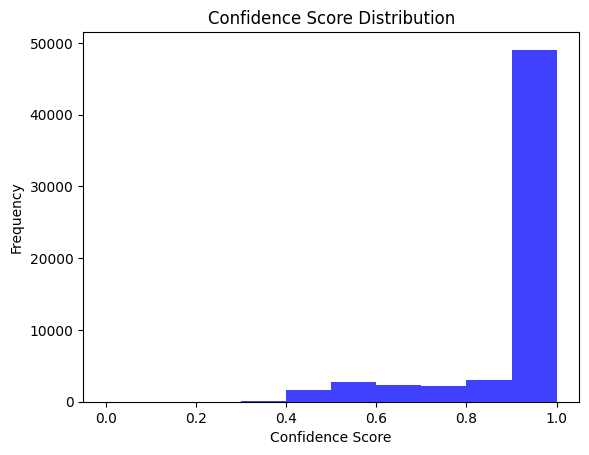

In [ ]:
# Confidence score for each prediction
confidence_scores = np.max(y_pred, axis=1)

# Confidence scores statistics
mean_confidence = round(np.mean(confidence_scores), 2)
std_confidence = round(np.std(confidence_scores), 2)
min_confidence = round(np.min(confidence_scores), 2)
max_confidence = round(np.max(confidence_scores), 2)

print(f"Mean Confidence: {mean_confidence}")
print(f"Std Confidence: {std_confidence}")
print(f"Min Confidence: {min_confidence}")
print(f"Max Confidence: {max_confidence}")

plt.hist(confidence_scores, bins=10, range=(0, 1), alpha=0.75, color='blue')
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.show()

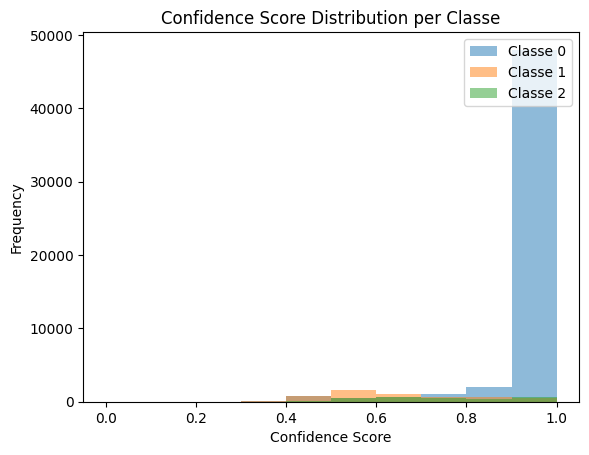

In [ ]:
# Raggruppare i confidence scores per classe predetta
class_confidences = {}
for cls in np.unique(y_pred_classes):
    class_confidences[cls] = confidence_scores[y_pred_classes == cls]

# Visualizzare la distribuzione dei confidence scores per ciascuna classe
for cls, confs in class_confidences.items():
    plt.hist(confs, bins=10, range=(0, 1), alpha=0.5, label=f'Classe {cls}')

plt.title('Confidence Score Distribution per Classe')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calcolare statistiche per ogni classe
for cls, confs in class_confidences.items():
    mean_confidence = np.mean(confs)
    std_confidence = np.std(confs)
    min_confidence = np.min(confs)
    max_confidence = np.max(confs)
    print(f"Classe {cls}:")
    print(f"  Mean Confidence: {mean_confidence:.2f}")
    print(f"  Std Confidence: {std_confidence:.2f}")
    print(f"  Min Confidence: {min_confidence:.2f}")
    print(f"  Max Confidence: {max_confidence:.2f}")

Classe 0:
  Mean Confidence: 0.96
  Std Confidence: 0.10
  Min Confidence: 0.34
  Max Confidence: 1.00
Classe 1:
  Mean Confidence: 0.65
  Std Confidence: 0.15
  Min Confidence: 0.34
  Max Confidence: 0.98
Classe 2:
  Mean Confidence: 0.73
  Std Confidence: 0.16
  Min Confidence: 0.34
  Max Confidence: 1.00
